In [128]:
%reset -f

In [129]:
#!/usr/bin/env python3
import pandas as pd
from typing import Union
import numpy as np
from tqdm import tqdm
import torch
from torch import nn
import re
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,10)
pd.set_option('display.max_rows', 10)

In [130]:
from scipy.signal import find_peaks

In [131]:
import bz2
import pickle
import _pickle as cPickle

In [132]:
# Load any compressed pickle file
def decompress_pickle(filename):
    data = bz2.BZ2File(filename, 'rb')
    data = cPickle.load(data)
    return data

In [133]:
# Pickle a file and then compress it into a file with extension 
def compressed_pickle(title, data):
    with bz2.BZ2File(title + '.pbz2', 'w') as f: 
        cPickle.dump(data, f)

In [134]:
def make_dataframe_from_data(data:dict)->pd.DataFrame:
    dataframe = pd.DataFrame(data=data)
    return dataframe

In [135]:
# Normalize the dataset between 0 and 1
def normalize_dataset(df:pd.DataFrame)->pd.DataFrame:
    # df = (df-df.min())/(df.max()-df.min())
    # or can do
    theta_min = df['theta'].min()
    theta_max = df['theta'].max()
    pitch_max = df['pitch'].max()
    pitch_min = df['pitch'].min()
    duty_cycle_min = df['duty_cycle'].min()
    duty_cycle_max = df['duty_cycle'].max()
    fill_factor_min = df['fill_factor'].min()
    fill_factor_max = df['fill_factor'].max()
    # lambda_min = df['lambda'].min()
    # lambda_max = df['lambda'].max()
    # trans_min = df['trans'].min()
    # trans_max = df['trans'].max()

    df['theta'] = (df['theta'] - theta_min) / (theta_max - theta_min)
    df['pitch'] = (df['pitch'] - pitch_min) / (pitch_max - pitch_min)
    df['duty_cycle'] = (df['duty_cycle'] - duty_cycle_min) / (duty_cycle_max - duty_cycle_min)
    df['fill_factor'] = (df['fill_factor'] - fill_factor_min) / (fill_factor_max - fill_factor_min)
    # df['lambda'] = (df['lambda'] - lambda_min) / (lambda_max - lambda_min)
    # df['trans'] = (df['trans'] - trans_min) / (trans_max - trans_min)
    return df

In [136]:
def engineering_steps_v2(dataframe:pd.DataFrame)->pd.DataFrame:
    simulations = []
    thetas = []
    pitchs = []
    duty_cycles = []
    fill_factors = []
    lambdas = []
    trans = []

    count = 0
    num_rows = dataframe.shape[0]
    for i in tqdm(range(num_rows)):
        wavelengths = dataframe.iloc[i]['lambda']
        transmissions = dataframe.iloc[i]['trans']

        indices = find_peaks(transmissions, distance=150, prominence=0.15, width=0.2)[0]
        peaks_wavs = [wavelengths[j] for j in indices]
        peaks_trans = [transmissions[j] for j in indices]

        if len(peaks_wavs) > 0:
            check1 = max(peaks_wavs) > 1.35 and max(peaks_wavs) < 1.65
            check2 = check1 and max(peaks_trans) > 0.1
            # take out peaks that are less 0.1
            # take out peaks that lie outside 1.35 and 1.65
            check_wavelength = (max(peaks_wavs)) < 1.35 or (max(peaks_wavs) > 1.65)
            if len(indices) == 1 and check2:
                count = count + 1
                simulations.append(dataframe.iloc[i]['simulation'])
                thetas.append(dataframe.iloc[i]['theta'])
                pitchs.append(dataframe.iloc[i]['pitch'])
                duty_cycles.append(dataframe.iloc[i]['duty_cycle'])
                fill_factors.append(dataframe.iloc[i]['fill_factor'])
                lambdas.append(dataframe.iloc[i]['lambda'])
                trans.append(dataframe.iloc[i]['trans'])

    data = {'simulation':simulations, 'theta':thetas, 'pitch':pitchs, 'duty_cycle':duty_cycles, 'fill_factor':fill_factors, 'lambda':lambdas, 'trans':trans}
    return make_dataframe_from_data(data)

In [137]:
dataset_file = 'dataset/new_dataset.pbz2'
dataframe = decompress_pickle(filename=dataset_file)
# delete rows in dataframe where Mode is 1
dataframe = dataframe[dataframe['Mode'] != 1]
# rename Theta to theta, Pitch to pitch, Duty Cycle to duty_cycle, Fill Factor to fill_factor, Lambda to lambda, Transmission to trans
dataframe = dataframe.rename(columns={"Theta":"theta", "Pitch":"pitch", "Duty Cycle":"duty_cycle", "Fill Factor":"fill_factor", "Lambda":"lambda", "Transmission":"trans"})
# multiply the values in dataframe['lambda'] by 1000000
dataframe['lambda'] = dataframe['lambda'] * 1000000
dataframe['simulation'] = dataframe.index + 1
dataframe

,theta,pitch,duty_cycle,fill_factor,Mode,lambda,trans,simulation
0,5.0,5.000000e-07,0.4,0.200000,0,"[1.4, 1.40124, 1.4024899999999998, 1.40373, 1....","[0.00024694, 0.000222525, 0.000200177, 0.00017...",1
2,5.0,5.000000e-07,0.4,0.257143,0,"[1.4, 1.40124, 1.4024899999999998, 1.40373, 1....","[0.000555697, 0.000525419, 0.000495302, 0.0004...",3
4,5.0,5.000000e-07,0.4,0.280000,0,"[1.3, 1.3, 1.3, 1.3, 1.31, 1.31, 1.31, 1.31, 1...","[0.000155323, 0.000114162, 8.32e-05, 6.43e-05,...",5
6,5.0,5.000000e-07,0.4,0.314286,0,"[1.4, 1.40124, 1.4024899999999998, 1.40373, 1....","[0.000805651, 0.000784795, 0.000761638, 0.0007...",7
8,5.0,5.000000e-07,0.4,0.360000,0,"[1.3, 1.3, 1.3, 1.3, 1.31, 1.31, 1.31, 1.31, 1...","[0.000758888, 0.000736973, 0.000699869, 0.0006...",9
...,...,...,...,...,...,...,...,...
11162,20.0,1.500000e-06,0.8,0.440000,0,"[1.3, 1.3, 1.3, 1.3, 1.31, 1.31, 1.31, 1.31, 1...","[0.000906643, 0.0010789, 0.00127815, 0.0014852...",11163
11164,20.0,1.500000e-06,0.8,0.485714,0,"[1.4, 1.40124, 1.4024899999999998, 1.40373, 1....","[0.00480186, 0.00491874, 0.00502532, 0.0051216...",11165
11166,20.0,1.500000e-06,0.8,0.520000,0,"[1.3, 1.3, 1.3, 1.3, 1.31, 1.31, 1.31, 1.31, 1...","[0.000573312, 0.000518888, 0.000524103, 0.0005...",11167
11168,20.0,1.500000e-06,0.8,0.542857,0,"[1.4, 1.40124, 1.4024899999999998, 1.40373, 1....","[0.00405141, 0.00416513, 0.00426947, 0.0043639...",11169


In [138]:
compressed_pickle(data=dataframe, title='dataset/mydatasetv2')

In [139]:
dataframe = decompress_pickle(filename='dataset/mydatasetv2.pbz2')
dataframe = engineering_steps_v2(dataframe)
dataframe

100%|██████████| 5586/5586 [00:00<00:00, 5767.77it/s]


,simulation,theta,pitch,duty_cycle,fill_factor,lambda,trans
0,329,5.0,7.000000e-07,0.400000,0.520000,"[1.3, 1.3, 1.3, 1.3, 1.31, 1.31, 1.31, 1.31, 1...","[0.000587724, 0.000313903, 0.000251931, 0.0004..."
1,337,5.0,7.000000e-07,0.480000,0.360000,"[1.3, 1.3, 1.3, 1.3, 1.31, 1.31, 1.31, 1.31, 1...","[0.0137364, 0.018896, 0.0232904, 0.0265295, 0...."
2,339,5.0,7.000000e-07,0.480000,0.440000,"[1.3, 1.3, 1.3, 1.3, 1.31, 1.31, 1.31, 1.31, 1...","[0.00229746, 0.00238441, 0.00198241, 0.0012466..."
3,341,5.0,7.000000e-07,0.480000,0.520000,"[1.3, 1.3, 1.3, 1.3, 1.31, 1.31, 1.31, 1.31, 1...","[0.0001724059999999, 0.000171295, 0.000215067,..."
4,343,5.0,7.000000e-07,0.480000,0.600000,"[1.3, 1.3, 1.3, 1.3, 1.31, 1.31, 1.31, 1.31, 1...","[0.00368185, 0.00381874, 0.00399309, 0.0041860..."
...,...,...,...,...,...,...,...
966,10877,20.0,1.357140e-06,0.457143,0.428571,"[1.4, 1.40124, 1.4024899999999998, 1.40373, 1....","[2.06172e-05, 3.27502e-05, 4.97131e-05, 7.2281..."
967,10879,20.0,1.357140e-06,0.457143,0.485714,"[1.4, 1.40124, 1.4024899999999998, 1.40373, 1....","[1.04704e-05, 4.29022e-06, -1.4300899999999996..."
968,10881,20.0,1.357140e-06,0.457143,0.542857,"[1.4, 1.40124, 1.4024899999999998, 1.40373, 1....","[9.71706e-05, 0.000106635, 0.000115976, 0.0001..."
969,10883,20.0,1.357140e-06,0.457143,0.600000,"[1.4, 1.40124, 1.4024899999999998, 1.40373, 1....","[6.95919e-05, 7.253850000000001e-05, 8.1621499..."


1


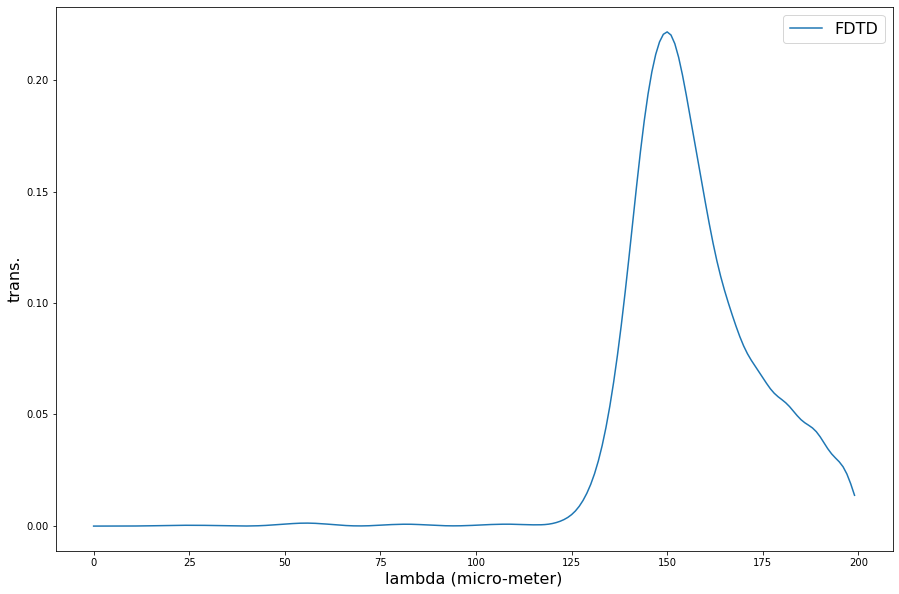

<Figure size 1080x720 with 0 Axes>

In [140]:
# num_rows = dataframe.shape[0]
num_rows = 100
# for row in range(2):
row = 1
print(row)
lambdas = np.flip(dataframe.iloc[row]['lambda'])
targets = np.flip(dataframe.iloc[row]['trans'])
plt.plot(targets, label='FDTD')
plt.xlabel('lambda (micro-meter)', fontsize=16)
plt.ylabel('trans.', fontsize=16)
plt.legend(fontsize=16)

plt.show()
plt.clf()

In [ ]:
# random_state = 42
# dataset_file = 'dataset/mydataset.pbz2'
# dataframe = decompress_pickle(filename=dataset_file)
# dataframe = engineering_steps_v2(dataframe=dataframe)
# dataframe = normalize_dataset(dataframe)
# # dataframe = dataframe.sample(frac=1, random_state=random_state)
# dataframe